绘制真实数据与生成数据的距离分布差异

In [1]:
import json
import pickle
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from geopy import distance

sns.set_theme()

In [2]:
geo = pd.read_csv('../../../traj_gen_exp_bj/data/BJ_Taxi/cleaned-data/roadmap.cleaned.geo')
real = pd.read_csv('../../../traj_gen_exp_bj/data/BJ_Taxi/cleaned-data/traj_tes_10000_random.cleaned.csv')
gene = pd.read_csv('../gene/new_gene_one_softmax/new_gene_one_softmax_seed0_2024-04-15_09-12-38.csv')
with open('../../../traj_gen_exp_bj/data/BJ_Taxi/ts_trajgen-output/partition/rid2small_region.pkl', 'rb') as file:
    rid2small_region = pickle.load(file)
with open('../../../traj_gen_exp_bj/data/BJ_Taxi/ts_trajgen-output/partition/small_region2rid.pkl', 'rb') as file:
    small_region2rid = pickle.load(file)

road_gps = []
for i, row in geo.iterrows():
    coordinates = eval(row['coordinates'])
    road_line = LineString(coordinates=coordinates)
    center_coord = road_line.centroid
    center_lon, center_lat = center_coord.x, center_coord.y
    road_gps.append((center_lon, center_lat))

real_distance = []
gene_distance = []

for _, row in tqdm(real.iterrows(), total=len(real)):
    rid_list = eval(row['rid_list'])
    travel_distance = 0
    for i in range(1, len(rid_list)):
        travel_distance += distance.distance((road_gps[rid_list[i-1]][1], road_gps[rid_list[i-1]][0]), (road_gps[rid_list[i]][1], road_gps[rid_list[i]][0])).kilometers
    real_distance.append(travel_distance)

for _, row in tqdm(gene.iterrows(), total=len(gene)):
    rid_list = eval(row['rid_list'])
    travel_distance = 0
    for i in range(1, len(rid_list)):
        travel_distance += distance.distance((road_gps[rid_list[i-1]][1], road_gps[rid_list[i-1]][0]), (road_gps[rid_list[i]][1], road_gps[rid_list[i]][0])).kilometers
    gene_distance.append(travel_distance)

real_distance = np.array(real_distance)
gene_distance = np.array(gene_distance)

100%|██████████| 2000/2000 [00:08<00:00, 222.99it/s]


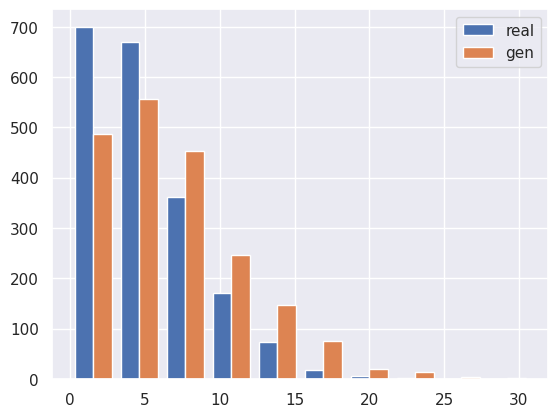

In [3]:
plt.hist([real_distance, gene_distance], label=['real', 'gen'])

plt.legend()
plt.show()

In [4]:
np.argmax(gene_distance - real_distance)

659

In [5]:
print(real_distance[659])
print(gene_distance[659])

11.917607074490476
26.180158325696656


分析下生成数据和真实数据差在哪里了

In [6]:
problem_real_rid_list = list(eval(real.loc[659, 'rid_list']))
problem_gene_rid_list = eval(gene.loc[659, 'rid_list'])

problem_real_region_list = [rid2small_region[problem_real_rid_list[0]]]
problem_gene_region_list = [rid2small_region[problem_gene_rid_list[0]]]

for i in range(1, len(problem_real_rid_list)):
    region = rid2small_region[problem_real_rid_list[i]]
    if region != problem_real_region_list[-1]:
        problem_real_region_list.append(region)

for i in range(1, len(problem_gene_rid_list)):
    region = rid2small_region[problem_gene_rid_list[i]]
    if region != problem_gene_region_list[-1]:
        problem_gene_region_list.append(region)

In [7]:
print(f'problem_real_rid_list: {problem_real_rid_list}')
print(f'problem_real_rid_list len: {len(problem_real_rid_list)}')
print(f'problem_gene_rid_list: {problem_gene_rid_list}')
print(f'problem_gene_rid_list len: {len(problem_gene_rid_list)}')

print(f'problem_real_region_list: {problem_real_region_list}')
print(f'problem_real_region_list len: {len(problem_real_region_list)}')
print(f'problem_gene_region_list: {problem_gene_region_list}')
print(f'problem_gene_region_list len: {len(problem_gene_region_list)}')

problem_real_rid_list: [1524, 1531, 1525, 1528, 14016, 34911, 38284, 38287, 39387, 1791, 3698, 1008, 25109, 1799, 882, 26993, 19034, 3011, 3010, 18975, 39028, 18970, 7988, 884, 1095, 885, 4462, 39115, 5161, 2596, 23446, 30586, 30583, 30579, 23442, 3050, 3044, 1011, 3707, 1958, 16873, 16870, 2954, 6564, 16862, 17470, 28230, 28235, 28240, 30287, 17454, 17453, 17451, 17447, 29281, 25332]
problem_real_rid_list len: 56
problem_gene_rid_list: [1524, 1531, 1525, 1528, 14016, 34911, 38284, 38287, 39387, 1791, 3698, 1010, 17402, 1470, 38636, 4643, 11322, 4875, 4647, 2605, 25107, 11429, 2601, 5247, 1472, 14264, 14266, 2509, 14293, 4890, 1877, 601, 23284, 23286, 2165, 2164, 7267, 25126, 23788, 4913, 14324, 1879, 4895, 4897, 14272, 4448, 4658, 33367, 1862, 1868, 20896, 33537, 33522, 20893, 33501, 34601, 19388, 19382, 26657, 3126, 26655, 26654, 19380, 19378, 21420, 1366, 24790, 24788, 24785, 24780, 24777, 21347, 1363, 8926, 22966, 8929, 8930, 21343, 21340, 27475, 27473, 21334, 21333, 3443, 24843, 3

In [8]:
# 可视化road级别上真实数据和生成数据的差异
vis_data_1 = dict()
vis_data_1['real'] = []
vis_data_1['gene'] = []

for rid in problem_real_rid_list:
    coordinates = eval(geo.loc[rid, 'coordinates'])
    for i in range(len(coordinates)):
        coordinates[i] = coordinates[i][::-1]
    vis_data_1['real'].append(coordinates)

for rid in problem_gene_rid_list:
    coordinates = eval(geo.loc[rid, 'coordinates'])
    for i in range(len(coordinates)):
        coordinates[i] = coordinates[i][::-1]
    vis_data_1['gene'].append(coordinates)

# 可视化region级别的真实数据轨迹
vis_data_2 = []

for region in problem_real_region_list:
    region_coordinates = []
    for rid in small_region2rid[region]:
        coordinates = eval(geo.loc[rid, 'coordinates'])
        for i in range(len(coordinates)):
            coordinates[i] = coordinates[i][::-1]
        region_coordinates.append(coordinates)
    vis_data_2.append(region_coordinates)

# 可视化region级别的生成数据轨迹
vis_data_3 = []

for region in problem_gene_region_list:
    region_coordinates = []
    for rid in small_region2rid[region]:
        coordinates = eval(geo.loc[rid, 'coordinates'])
        for i in range(len(coordinates)):
            coordinates[i] = coordinates[i][::-1]
        region_coordinates.append(coordinates)
    vis_data_3.append(region_coordinates)

with open('./vis1_1.json', 'w') as file:
    json.dump(vis_data_1, file)
with open('./vis1_2.json', 'w') as file:
    json.dump(vis_data_2, file)
with open('./vis1_3.json', 'w') as file:
    json.dump(vis_data_3, file)

In [9]:
print(f'problem_real_region_list: {problem_real_region_list}')
print(f'problem_real_region_list len: {len(problem_real_region_list)}')
print(f'problem_gene_region_list: {problem_gene_region_list}')
print(f'problem_gene_region_list len: {len(problem_gene_region_list)}')

problem_real_region_list: [2155, 2182, 2179, 2172, 2162, 1907, 1888, 1851, 1847, 1261, 1946, 1938]
problem_real_region_list len: 12
problem_gene_region_list: [2155, 2172, 1920, 1907, 1895, 1892, 1688, 1677, 1938]
problem_gene_region_list len: 9


In [10]:
for region in problem_real_region_list:
    print(len(small_region2rid[region]), end=' ')
print()

for region in problem_gene_region_list:
    print(len(small_region2rid[region]), end=' ')
print()

818 1 1 798 1 773 1 593 1 770 1 709 
818 798 1 773 1 1 781 1 709 
